In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets
import os
os.chdir('./2-2/')
import opt_utils

# Gradient Descent

In [2]:
def update_params_with_gd(params, grads, alpha):
    L = len(params) // 2
    for l in range(L):
        params[f'W{l+1}'] -= alpha * grads[f'dW{l+1}']
        params[f'b{l+1}'] -= alpha * grads[f'db{l+1}']
    return params

# Mini-batch Gradient Descent

## shuffle and get mini-batches

In [3]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=1):
    
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    #shuffle
    permutattion = list(np.random.permutation(m))
    shuffled_X = X[:, permutattion]
    shuffled_Y = Y[:, permutattion]
    #segmentation
    n_complete_batches = m // mini_batch_size
    for n in range(n_complete_batches):
        mini_batch_X = shuffled_X[:, n*mini_batch_size : (n+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, n*mini_batch_size : (n+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, n_complete_batches*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, n_complete_batches*mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches

# Momentum

## initial V

In [4]:
def init_momentum(params:dict):

    L = len(params) // 2
    V = {}

    for l in range(L):
        V[f'dW{l+1}'] = np.zeros_like(params[f'W{l+1}'])
        V[f'db{l+1}'] = np.zeros_like(params[f'b{l+1}'])

    return V

## update parameters with momentum

In [5]:
def update_params_with_momentum(params, grads, V, beta, alpha):

    L = len(params) // 2
    for l in range(L):
        V[f'dW{l+1}'] = beta * V[f'dW{l+1}'] + (1-beta) * grads[f'dW{l+1}']
        V[f'db{l+1}'] = beta * V[f'db{l+1}'] + (1-beta) * grads[f'db{l+1}']
        params[f'W{l+1}'] -= alpha * V[f'dW{l+1}']
        params[f'b{l+1}'] -= alpha * V[f'db{l+1}']

    return params, V

# Adam

## initial V, S

In [6]:
def init_adam(params:dict):

    L = len(params) // 2
    V = {}
    S = {}

    for l in range(L):
        V[f'dW{l+1}'] = np.zeros_like(params[f'W{l+1}'])
        V[f'db{l+1}'] = np.zeros_like(params[f'b{l+1}'])
        S[f'dW{l+1}'] = np.zeros_like(params[f'W{l+1}'])
        S[f'db{l+1}'] = np.zeros_like(params[f'b{l+1}'])

    return V, S

## update parameters with adam

In [7]:
def update_params_with_adam(params, grads, V, S, t, alpha, beta1=0.9, beta2=0.999):

    e = 1e-8
    L = len(params) // 2
    
    for l in range(L):

        V[f'dW{l+1}'] = beta1 * V[f'dW{l+1}'] + (1-beta1) * grads[f'dW{l+1}']
        V[f'db{l+1}'] = beta1 * V[f'db{l+1}'] + (1-beta1) * grads[f'db{l+1}']

        Vw_corrected = V[f'dW{l+1}'] / (1 - beta1**t)
        Vb_corrected = V[f'db{l+1}'] / (1 - beta1**t)

        S[f'dW{l+1}'] = beta2 * S[f'dW{l+1}'] + (1-beta2) * np.square(grads[f'dW{l+1}'])
        S[f'db{l+1}'] = beta2 * S[f'db{l+1}'] + (1-beta2) * np.square(grads[f'db{l+1}'])

        Sw_corrected = S[f'dW{l+1}'] / (1 - beta2**t)
        Sb_corrected = S[f'db{l+1}'] / (1 - beta2**t)

        params[f'W{l+1}'] -= alpha * (Vw_corrected / np.sqrt(Sw_corrected + e))
        params[f'b{l+1}'] -= alpha * (Vb_corrected / np.sqrt(Sb_corrected + e))

    return params, V, S

# Test Model

In [46]:
def model_opt(X, Y, layer_dims, optimizer:str, alpha=0.08, mini_batch_size=64, beta1=0.9, beta2=0.999, epochs=10000):

    L = len(layer_dims)
    costs = []
    t = 0
    seed = 1

    # initial weights
    params = opt_utils.initialize_parameters(layer_dims)

    # initial optimizer
    if optimizer == 'gd':
        pass
    elif optimizer == 'momentum':
        V = init_momentum(params)
    elif optimizer == 'adam':
        V, S = init_adam(params)
    else:
        print('Unexcepted optimizer!')
    
    # train
    for i in range(epochs):

        ## shuffle and get new mini_batches
        seed += 1
        mini_batches = random_mini_batches(X, Y,mini_batch_size, seed)
        
        for batch in mini_batches:
            ### get X,Y in batch
            mini_X, mini_Y = batch
            ### forward propagate
            A3, cache = opt_utils.forward_propagation(mini_X, params)
            ### compute loss
            cost = opt_utils.compute_cost(A3, mini_Y)
            ### backward propagate
            grads = opt_utils.backward_propagation(mini_X, mini_Y, cache)
            ### update params
            if optimizer == 'gd':
                params = update_params_with_gd(params, grads, alpha)
            elif optimizer == 'momentum':
                params, V = update_params_with_momentum(params, grads, V, beta1, alpha)
            elif optimizer == 'adam':
                t += 1
                params, V, S = update_params_with_adam(params, grads, V, S, t, alpha, beta1, beta2)
            else:
                print('Unexcepted optimizer!')
        
        if (i+1) % 100 == 0:
            costs.append(cost)
            print(f'No.{i+1} iteration\'s loss: {cost}')

    plt.plot(costs)
    plt.xlabel('# iterations per 100')
    plt.ylabel('loss')
    plt.title(f'{optimizer} loss circle')
    plt.show()

    return params


# load dataset and test

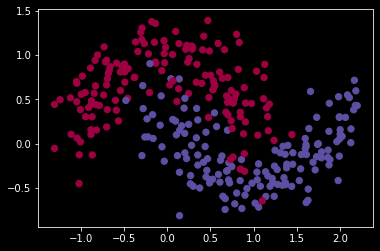

In [15]:
train_X, train_Y = opt_utils.load_dataset(is_plot=True)

No.100 iteration's loss: 0.686919697155591
No.200 iteration's loss: 0.6799228571996799
No.300 iteration's loss: 0.6920945057050946
No.400 iteration's loss: 0.7087821511719891
No.500 iteration's loss: 0.7006384323183177
No.600 iteration's loss: 0.6780544079515629
No.700 iteration's loss: 0.6730494453317836
No.800 iteration's loss: 0.6649403129390505
No.900 iteration's loss: 0.6638956025336973
No.1000 iteration's loss: 0.6311725802713699
No.1100 iteration's loss: 0.6251318531627208
No.1200 iteration's loss: 0.6645295461064682
No.1300 iteration's loss: 0.6416063704473627
No.1400 iteration's loss: 0.6230053511793445
No.1500 iteration's loss: 0.6499834748625611
No.1600 iteration's loss: 0.6040508655437523
No.1700 iteration's loss: 0.6135468794301245
No.1800 iteration's loss: 0.6014499011174393
No.1900 iteration's loss: 0.6566110969866107
No.2000 iteration's loss: 0.6148696349834276
No.2100 iteration's loss: 0.6634256657365143
No.2200 iteration's loss: 0.6276311704392077
No.2300 iteration's 

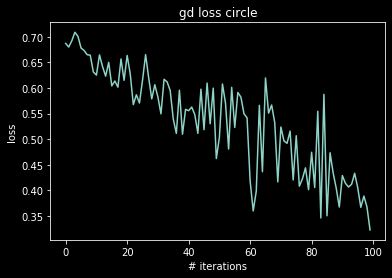

In [16]:
layer_dims = [train_X.shape[0], 5, 2, 1]
np.random.seed(3)
params = model_opt(train_X, train_Y, layer_dims, optimizer='gd', alpha=0.0008, mini_batch_size=64, beta1=0.9, beta2=0.999, epochs=10000)

Accuracy: 0.8533333333333334


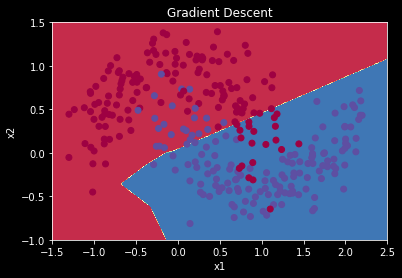

In [20]:
prediction = opt_utils.predict(train_X, train_Y, params)

plt.title('Gradient Descent')
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
opt_utils.plot_decision_boundary(lambda x: opt_utils.predict_dec(params, x.T), train_X, train_Y)

No.100 iteration's loss: 0.6869980267090634
No.200 iteration's loss: 0.6799803487964559
No.300 iteration's loss: 0.6921534585028023
No.400 iteration's loss: 0.7088227361085461
No.500 iteration's loss: 0.7006927621828504
No.600 iteration's loss: 0.6781105126326061
No.700 iteration's loss: 0.6731311922819775
No.800 iteration's loss: 0.6650056585942262
No.900 iteration's loss: 0.6639433529349513
No.1000 iteration's loss: 0.6312868788005959
No.1100 iteration's loss: 0.6252324745178476
No.1200 iteration's loss: 0.6645887504140928
No.1300 iteration's loss: 0.6417007420292404
No.1400 iteration's loss: 0.6231078547534873
No.1500 iteration's loss: 0.6500391102499394
No.1600 iteration's loss: 0.6041671598748464
No.1700 iteration's loss: 0.6137025171232522
No.1800 iteration's loss: 0.601558469022113
No.1900 iteration's loss: 0.6566785177191924
No.2000 iteration's loss: 0.6149734181256032
No.2100 iteration's loss: 0.6634959171218006
No.2200 iteration's loss: 0.6277619951953753
No.2300 iteration's 

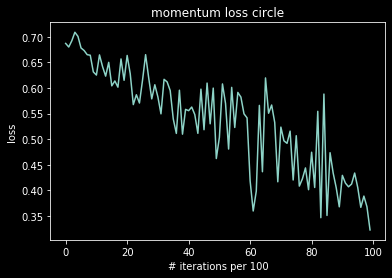

In [47]:
layer_dims = [train_X.shape[0], 5, 2, 1]
np.random.seed(3)
params = model_opt(train_X, train_Y, layer_dims, optimizer='momentum', alpha=0.0008, mini_batch_size=64, beta1=0.9, beta2=0.999, epochs=10000)

Accuracy: 0.8533333333333334


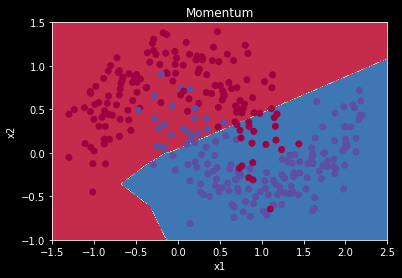

In [48]:
prediction = opt_utils.predict(train_X, train_Y, params)

plt.title('Momentum')
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
opt_utils.plot_decision_boundary(lambda x: opt_utils.predict_dec(params, x.T), train_X, train_Y)

No.100 iteration's loss: 0.5211616927046354
No.200 iteration's loss: 0.42885745507905776
No.300 iteration's loss: 0.36241524953077864
No.400 iteration's loss: 0.26774594890127396
No.500 iteration's loss: 0.21660380229649234
No.600 iteration's loss: 0.30883160211399296
No.700 iteration's loss: 0.17220021385686854
No.800 iteration's loss: 0.17486812551265424
No.900 iteration's loss: 0.21001616561017275
No.1000 iteration's loss: 0.18257333081299398
No.1100 iteration's loss: 0.1320032976552048
No.1200 iteration's loss: 0.1660993781596029
No.1300 iteration's loss: 0.20902866169799175
No.1400 iteration's loss: 0.039392291027728
No.1500 iteration's loss: 0.14327465818540183
No.1600 iteration's loss: 0.16732555473660157
No.1700 iteration's loss: 0.09503008468547339
No.1800 iteration's loss: 0.0730766573398262
No.1900 iteration's loss: 0.09002995967786732
No.2000 iteration's loss: 0.16751598321759822
No.2100 iteration's loss: 0.05527605344955182
No.2200 iteration's loss: 0.13544127127055794
No.

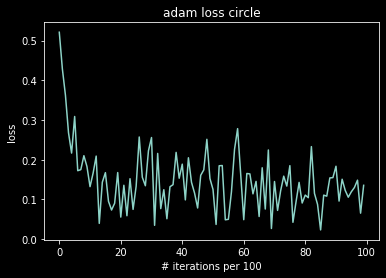

In [49]:
layer_dims = [train_X.shape[0], 5, 2, 1]
np.random.seed(3)
params = model_opt(train_X, train_Y, layer_dims, optimizer='adam', alpha=0.0008, mini_batch_size=64, beta1=0.9, beta2=0.999, epochs=10000)

Accuracy: 0.94


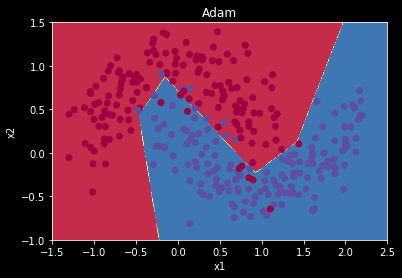

In [50]:
prediction = opt_utils.predict(train_X, train_Y, params)

plt.title('Adam')
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
opt_utils.plot_decision_boundary(lambda x: opt_utils.predict_dec(params, x.T), train_X, train_Y)

+ momentum : 因为beta1取的0.9接近1，所以跟gradient descent很相似，如果beta1取小一点可能获得更好的效果
+ adam ：在beta1取值为0.9的时候，beta2取值0.999就获得了极好的效果，明显加速了收敛速度